In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
    allow_growth=True
    ))

In [2]:
import pandas as pd
import os
target_path = '../data/LOG_G/fix_ball_robot/bk_stable/'
contents = os.listdir(target_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    print(target_path+contents[c])
    n_data = pd.read_csv(target_path+contents[c],header=None)
    data = pd.concat([data,n_data])

print(len(data))
d = data
#print(ball)
#print(joy)

../data/LOG_G/fix_ball_robot/bk_stable/log201808031448.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031442.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031431.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031503.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031429.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031508.csv
../data/LOG_G/fix_ball_robot/bk_stable/log201808031618.csv
21714


In [3]:
d.columns = ['l_bx','l_by','l_pole0x','l_pole0y','l_pole1x','l_pole1y','g_bx','g_by','g_pole0x','g_pole0y','g_pole1x','g_pole1y','g_px','g_py','g_pth','ljx','ljy','rjx','rjy']
#d = d[d.bx!=-1]

In [4]:
'''
from sklearn.cross_validation import train_test_split
t1 = []
t2 = []
def f1(x,y):
    return y * np.sin(x) + np.square(x)
def f2(x,y):
    return x * np.cos(y) + np.square(y)
for a in range(1000):
    r = np.array([np.random.rand(), np.random.rand()])
    t1.append(r)
    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))
IN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)

IN_train = np.array(IN_train)
IN_test = np.array(IN_test)
TAR_train = np.array(TAR_train)
TAR_test = np.array(TAR_test)
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
print(f1(1,1))
print(f2(1,1))
'''

'\nfrom sklearn.cross_validation import train_test_split\nt1 = []\nt2 = []\ndef f1(x,y):\n    return y * np.sin(x) + np.square(x)\ndef f2(x,y):\n    return x * np.cos(y) + np.square(y)\nfor a in range(1000):\n    r = np.array([np.random.rand(), np.random.rand()])\n    t1.append(r)\n    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))\nIN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)\n\nIN_train = np.array(IN_train)\nIN_test = np.array(IN_test)\nTAR_train = np.array(TAR_train)\nTAR_test = np.array(TAR_test)\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\nprint(f1(1,1))\nprint(f2(1,1))\n'

In [5]:
from sklearn.cross_validation import train_test_split
l_ball = np.array(d.iloc[:,0:2])   #  0, 1
l_pole0 = np.array(d.iloc[:,2:4])  #  2, 3
l_pole1 = np.array(d.iloc[:,4:6])  #  4, 5
g_ball = np.array(d.iloc[:,6:8])   #  6, 7
g_pole0 = np.array(d.iloc[:,8:10]) #  8, 9
g_pole1 = np.array(d.iloc[:,10:12])# 10,11
g_pos = np.array(d.iloc[:,12:15])  # 12,13,14
ljoy = np.array(d.iloc[:,15:17])   # 15,16
rjoy = np.array(d.iloc[:,17:19])   # 17,18

input_d = np.array(d.iloc[:,0:2])
output_d = np.array(d.iloc[:,15:18])
print(input_d.shape)
print(output_d.shape)

IN_train, IN_test, TAR_train, TAR_test = train_test_split(input_d,output_d,test_size=0.1,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
#IN_train = IN_train/100.0
#IN_test = IN_test/100.0
for t in range(10):
    print(IN_train[t])
'''
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
'''

(21714, 2)
(21714, 3)
[0.43185344 0.10151021]
[ 1.78298985 -0.3118574 ]
[0.25995545 0.11071291]
[ 0.47647729 -0.02984936]
[ 1.71417015 -1.08827424]
[ 0.23358732 -0.08559513]
[0.3090431  0.07475483]
[0.68679425 0.51421218]
[ 0.44453414 -0.12894753]
[1.14850254 0.4321522 ]


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\n'

In [6]:
#　初期化
sess = tf.Session(config=config)
test_sess = tf.Session(config=config)

IN_size = 2
TAR_size = 3
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

In [7]:
#hidden_size = [100]
hidden_size = [10,5,3]
batch_size = 100
iter_size = 80000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize] )))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize])))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]
print(final_output)

Tensor("Relu:0", shape=(?, 10), dtype=float32)
Tensor("Relu_1:0", shape=(?, 5), dtype=float32)
Tensor("Relu_2:0", shape=(?, 3), dtype=float32)
Tensor("Add_3:0", shape=(?, 3), dtype=float32)


In [8]:
#　学習
loss = tf.losses.mean_squared_error(TARGET,final_output)
test_loss = tf.losses.mean_squared_error(TARGET,final_output)
opt = tf.train.AdamOptimizer(0.001)
#opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)
test_sess.run(init)
loss_vec=[]
test_loss_vec=[]
for i in range(iter_size):
    train_rand_index = np.random.choice(len(IN_train), size=batch_size,replace=False)
    train_rand_in = IN_train[train_rand_index]
    train_rand_tar = TAR_train[train_rand_index]
    sess.run(train_step, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar})
    loss_vec.append(sess.run(loss, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar}))
    
    test_rand_index = np.random.choice(len(IN_test), size=batch_size,replace=False)
    test_rand_in = IN_test[test_rand_index]
    test_rand_tar = TAR_test[test_rand_index]
    test_sess.run(train_step, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar})
    test_loss_vec.append(test_sess.run(test_loss, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar}))
    
    if (i+1)%25==0:
#        print(sess.run(INPUT, feed_dict={INPUT:rand_in, TARGET: rand_tar}))
        print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

Generation:25, Loss = 1649.4989
Generation:50, Loss = 1429.3917
Generation:75, Loss = 910.393
Generation:100, Loss = 449.56366
Generation:125, Loss = 312.5169
Generation:150, Loss = 220.97977
Generation:175, Loss = 200.94838
Generation:200, Loss = 85.63635
Generation:225, Loss = 65.03341
Generation:250, Loss = 52.439865
Generation:275, Loss = 37.139835
Generation:300, Loss = 32.676033
Generation:325, Loss = 29.833246
Generation:350, Loss = 28.996315
Generation:375, Loss = 26.212307
Generation:400, Loss = 24.620756
Generation:425, Loss = 23.919062
Generation:450, Loss = 24.59818
Generation:475, Loss = 23.47123
Generation:500, Loss = 23.949114
Generation:525, Loss = 22.559301
Generation:550, Loss = 23.428192
Generation:575, Loss = 21.733864
Generation:600, Loss = 21.450777
Generation:625, Loss = 21.042082
Generation:650, Loss = 21.179932
Generation:675, Loss = 20.040133
Generation:700, Loss = 19.939999
Generation:725, Loss = 20.02635
Generation:750, Loss = 20.115911
Generation:775, Loss 

Generation:6025, Loss = 0.7296654
Generation:6050, Loss = 0.0953276
Generation:6075, Loss = 0.100962706
Generation:6100, Loss = 0.7319903
Generation:6125, Loss = 0.7359786
Generation:6150, Loss = 0.72141564
Generation:6175, Loss = 0.09254591
Generation:6200, Loss = 0.09141559
Generation:6225, Loss = 0.09116552
Generation:6250, Loss = 0.10141099
Generation:6275, Loss = 0.12855057
Generation:6300, Loss = 0.7062019
Generation:6325, Loss = 0.07468759
Generation:6350, Loss = 0.093890786
Generation:6375, Loss = 0.09905204
Generation:6400, Loss = 0.7133968
Generation:6425, Loss = 0.101983
Generation:6450, Loss = 0.10339687
Generation:6475, Loss = 0.7022285
Generation:6500, Loss = 0.07450792
Generation:6525, Loss = 0.09738742
Generation:6550, Loss = 0.71324325
Generation:6575, Loss = 0.08542784
Generation:6600, Loss = 0.09781002
Generation:6625, Loss = 0.08223706
Generation:6650, Loss = 0.07025766
Generation:6675, Loss = 0.71182334
Generation:6700, Loss = 0.7039652
Generation:6725, Loss = 0.11

Generation:11850, Loss = 0.09063999
Generation:11875, Loss = 0.08498571
Generation:11900, Loss = 0.09241731
Generation:11925, Loss = 0.07342777
Generation:11950, Loss = 0.08926593
Generation:11975, Loss = 0.07321005
Generation:12000, Loss = 0.08551177
Generation:12025, Loss = 0.087144166
Generation:12050, Loss = 0.0836355
Generation:12075, Loss = 0.0927742
Generation:12100, Loss = 0.0806054
Generation:12125, Loss = 0.07705071
Generation:12150, Loss = 0.0801599
Generation:12175, Loss = 0.081768125
Generation:12200, Loss = 0.07578728
Generation:12225, Loss = 0.077683456
Generation:12250, Loss = 0.07495922
Generation:12275, Loss = 0.073462985
Generation:12300, Loss = 0.075175054
Generation:12325, Loss = 0.07013138
Generation:12350, Loss = 0.07923102
Generation:12375, Loss = 0.07976797
Generation:12400, Loss = 0.09427222
Generation:12425, Loss = 0.07610492
Generation:12450, Loss = 0.083871774
Generation:12475, Loss = 0.076173775
Generation:12500, Loss = 0.101544715
Generation:12525, Loss =

Generation:17550, Loss = 0.075866155
Generation:17575, Loss = 0.06834288
Generation:17600, Loss = 0.08656997
Generation:17625, Loss = 0.071279675
Generation:17650, Loss = 0.081646934
Generation:17675, Loss = 0.07716713
Generation:17700, Loss = 0.072143406
Generation:17725, Loss = 0.08542669
Generation:17750, Loss = 0.09208624
Generation:17775, Loss = 0.07587111
Generation:17800, Loss = 0.07679868
Generation:17825, Loss = 0.070225865
Generation:17850, Loss = 0.0735864
Generation:17875, Loss = 0.08008592
Generation:17900, Loss = 0.08638813
Generation:17925, Loss = 0.06392903
Generation:17950, Loss = 0.08426961
Generation:17975, Loss = 0.08836999
Generation:18000, Loss = 0.087232046
Generation:18025, Loss = 0.0771664
Generation:18050, Loss = 0.08084796
Generation:18075, Loss = 0.082396716
Generation:18100, Loss = 0.07012282
Generation:18125, Loss = 0.07706235
Generation:18150, Loss = 0.07600536
Generation:18175, Loss = 0.07592229
Generation:18200, Loss = 0.087910846
Generation:18225, Loss

Generation:23250, Loss = 0.06710648
Generation:23275, Loss = 0.06576605
Generation:23300, Loss = 0.07797855
Generation:23325, Loss = 0.07372195
Generation:23350, Loss = 0.064038366
Generation:23375, Loss = 0.070341654
Generation:23400, Loss = 0.063721895
Generation:23425, Loss = 0.065846376
Generation:23450, Loss = 0.07849631
Generation:23475, Loss = 0.06995871
Generation:23500, Loss = 0.07180313
Generation:23525, Loss = 0.06660239
Generation:23550, Loss = 0.07179479
Generation:23575, Loss = 0.0679739
Generation:23600, Loss = 0.074400485
Generation:23625, Loss = 0.07712779
Generation:23650, Loss = 0.07940821
Generation:23675, Loss = 0.07449551
Generation:23700, Loss = 0.0789034
Generation:23725, Loss = 0.05603704
Generation:23750, Loss = 0.07081391
Generation:23775, Loss = 0.06152907
Generation:23800, Loss = 0.08101418
Generation:23825, Loss = 0.06914869
Generation:23850, Loss = 0.07597089
Generation:23875, Loss = 0.08863146
Generation:23900, Loss = 0.08792323
Generation:23925, Loss = 

Generation:28950, Loss = 0.06347272
Generation:28975, Loss = 0.06509034
Generation:29000, Loss = 0.06496225
Generation:29025, Loss = 0.07003233
Generation:29050, Loss = 0.06852927
Generation:29075, Loss = 0.06717256
Generation:29100, Loss = 0.06981557
Generation:29125, Loss = 0.06304004
Generation:29150, Loss = 0.06653937
Generation:29175, Loss = 0.058599398
Generation:29200, Loss = 0.06376805
Generation:29225, Loss = 0.065298945
Generation:29250, Loss = 0.070493154
Generation:29275, Loss = 0.060415886
Generation:29300, Loss = 0.06899993
Generation:29325, Loss = 0.06846715
Generation:29350, Loss = 0.068227746
Generation:29375, Loss = 0.07200208
Generation:29400, Loss = 0.061764438
Generation:29425, Loss = 0.055280026
Generation:29450, Loss = 0.065009736
Generation:29475, Loss = 0.072185956
Generation:29500, Loss = 0.056676965
Generation:29525, Loss = 0.07113927
Generation:29550, Loss = 0.066047706
Generation:29575, Loss = 0.06911938
Generation:29600, Loss = 0.06417731
Generation:29625,

Generation:34600, Loss = 0.058410943
Generation:34625, Loss = 0.06545319
Generation:34650, Loss = 0.0498097
Generation:34675, Loss = 0.06408872
Generation:34700, Loss = 0.064673826
Generation:34725, Loss = 0.06703911
Generation:34750, Loss = 0.058649458
Generation:34775, Loss = 0.0691699
Generation:34800, Loss = 0.063269205
Generation:34825, Loss = 0.055898566
Generation:34850, Loss = 0.08187476
Generation:34875, Loss = 0.07017715
Generation:34900, Loss = 0.062446117
Generation:34925, Loss = 0.07097248
Generation:34950, Loss = 0.07347127
Generation:34975, Loss = 0.06596903
Generation:35000, Loss = 0.061921585
Generation:35025, Loss = 0.059319764
Generation:35050, Loss = 0.072301805
Generation:35075, Loss = 0.06700635
Generation:35100, Loss = 0.05919625
Generation:35125, Loss = 0.046617128
Generation:35150, Loss = 0.06695675
Generation:35175, Loss = 0.05664213
Generation:35200, Loss = 0.06771145
Generation:35225, Loss = 0.06659162
Generation:35250, Loss = 0.07317832
Generation:35275, Lo

Generation:40250, Loss = 0.06557579
Generation:40275, Loss = 0.06835094
Generation:40300, Loss = 0.06609663
Generation:40325, Loss = 0.07085495
Generation:40350, Loss = 0.06561351
Generation:40375, Loss = 0.07543704
Generation:40400, Loss = 0.064834274
Generation:40425, Loss = 0.06334576
Generation:40450, Loss = 0.06497193
Generation:40475, Loss = 0.06569478
Generation:40500, Loss = 0.06748778
Generation:40525, Loss = 0.06509881
Generation:40550, Loss = 0.05211359
Generation:40575, Loss = 0.072153166
Generation:40600, Loss = 0.059156734
Generation:40625, Loss = 0.06969419
Generation:40650, Loss = 0.062776074
Generation:40675, Loss = 0.062528625
Generation:40700, Loss = 0.06775006
Generation:40725, Loss = 0.063582696
Generation:40750, Loss = 0.062077146
Generation:40775, Loss = 0.07176853
Generation:40800, Loss = 0.06488079
Generation:40825, Loss = 0.07107404
Generation:40850, Loss = 0.07194225
Generation:40875, Loss = 0.06906307
Generation:40900, Loss = 0.058530774
Generation:40925, Lo

Generation:45900, Loss = 0.062795036
Generation:45925, Loss = 0.05785808
Generation:45950, Loss = 0.061702315
Generation:45975, Loss = 0.060305778
Generation:46000, Loss = 0.05844581
Generation:46025, Loss = 0.07080631
Generation:46050, Loss = 0.05922869
Generation:46075, Loss = 0.06380359
Generation:46100, Loss = 0.065142244
Generation:46125, Loss = 0.05936652
Generation:46150, Loss = 0.059208024
Generation:46175, Loss = 0.06932793
Generation:46200, Loss = 0.06930828
Generation:46225, Loss = 0.060788155
Generation:46250, Loss = 0.06705104
Generation:46275, Loss = 0.0626912
Generation:46300, Loss = 0.060059547
Generation:46325, Loss = 0.07186428
Generation:46350, Loss = 0.068668656
Generation:46375, Loss = 0.06738365
Generation:46400, Loss = 0.078319006
Generation:46425, Loss = 0.06786618
Generation:46450, Loss = 0.06950132
Generation:46475, Loss = 0.06057123
Generation:46500, Loss = 0.06052281
Generation:46525, Loss = 0.06339322
Generation:46550, Loss = 0.06470211
Generation:46575, Lo

Generation:51550, Loss = 0.06861613
Generation:51575, Loss = 0.06800995
Generation:51600, Loss = 0.05865743
Generation:51625, Loss = 0.05037801
Generation:51650, Loss = 0.061511524
Generation:51675, Loss = 0.06184056
Generation:51700, Loss = 0.05011209
Generation:51725, Loss = 0.06728322
Generation:51750, Loss = 0.066814914
Generation:51775, Loss = 0.056705456
Generation:51800, Loss = 0.06451006
Generation:51825, Loss = 0.050179668
Generation:51850, Loss = 0.060755935
Generation:51875, Loss = 0.06509124
Generation:51900, Loss = 0.06110868
Generation:51925, Loss = 0.066741906
Generation:51950, Loss = 0.06203091
Generation:51975, Loss = 0.057745088
Generation:52000, Loss = 0.07212618
Generation:52025, Loss = 0.07109559
Generation:52050, Loss = 0.06875539
Generation:52075, Loss = 0.07206215
Generation:52100, Loss = 0.057522457
Generation:52125, Loss = 0.065172985
Generation:52150, Loss = 0.064784735
Generation:52175, Loss = 0.06272338
Generation:52200, Loss = 0.066255465
Generation:52225,

Generation:57200, Loss = 0.06298587
Generation:57225, Loss = 0.056993313
Generation:57250, Loss = 0.07039461
Generation:57275, Loss = 0.061026197
Generation:57300, Loss = 0.07109906
Generation:57325, Loss = 0.07240433
Generation:57350, Loss = 0.06617726
Generation:57375, Loss = 0.07789149
Generation:57400, Loss = 0.07321361
Generation:57425, Loss = 0.069081455
Generation:57450, Loss = 0.06079529
Generation:57475, Loss = 0.061422374
Generation:57500, Loss = 0.06509371
Generation:57525, Loss = 0.072884865
Generation:57550, Loss = 0.0659297
Generation:57575, Loss = 0.06424744
Generation:57600, Loss = 0.057654373
Generation:57625, Loss = 0.072897606
Generation:57650, Loss = 0.058806624
Generation:57675, Loss = 0.06511041
Generation:57700, Loss = 0.060120188
Generation:57725, Loss = 0.059389476
Generation:57750, Loss = 0.06434
Generation:57775, Loss = 0.052551836
Generation:57800, Loss = 0.06747495
Generation:57825, Loss = 0.072693355
Generation:57850, Loss = 0.06228295
Generation:57875, Lo

Generation:62850, Loss = 0.061684977
Generation:62875, Loss = 0.06072262
Generation:62900, Loss = 0.07228754
Generation:62925, Loss = 0.05376569
Generation:62950, Loss = 0.064686544
Generation:62975, Loss = 0.058837146
Generation:63000, Loss = 0.06231461
Generation:63025, Loss = 0.060841184
Generation:63050, Loss = 0.06678286
Generation:63075, Loss = 0.06483527
Generation:63100, Loss = 0.06319182
Generation:63125, Loss = 0.06082586
Generation:63150, Loss = 0.06061006
Generation:63175, Loss = 0.06292999
Generation:63200, Loss = 0.05604088
Generation:63225, Loss = 0.053203948
Generation:63250, Loss = 0.06748212
Generation:63275, Loss = 0.0611945
Generation:63300, Loss = 0.059058737
Generation:63325, Loss = 0.06762888
Generation:63350, Loss = 0.06445052
Generation:63375, Loss = 0.07014719
Generation:63400, Loss = 0.06900427
Generation:63425, Loss = 0.063321225
Generation:63450, Loss = 0.06548828
Generation:63475, Loss = 0.065670736
Generation:63500, Loss = 0.06444636
Generation:63525, Los

Generation:68500, Loss = 0.063508414
Generation:68525, Loss = 0.056331277
Generation:68550, Loss = 0.062510245
Generation:68575, Loss = 0.07389814
Generation:68600, Loss = 0.06005143
Generation:68625, Loss = 0.07541856
Generation:68650, Loss = 0.06952315
Generation:68675, Loss = 0.06728276
Generation:68700, Loss = 0.05169787
Generation:68725, Loss = 0.064273514
Generation:68750, Loss = 0.06332606
Generation:68775, Loss = 0.063686304
Generation:68800, Loss = 0.05841491
Generation:68825, Loss = 0.06553593
Generation:68850, Loss = 0.06512576
Generation:68875, Loss = 0.06954057
Generation:68900, Loss = 0.066477396
Generation:68925, Loss = 0.071670346
Generation:68950, Loss = 0.06368852
Generation:68975, Loss = 0.058709756
Generation:69000, Loss = 0.0615672
Generation:69025, Loss = 0.06549618
Generation:69050, Loss = 0.0597436
Generation:69075, Loss = 0.05679728
Generation:69100, Loss = 0.06284137
Generation:69125, Loss = 0.05862191
Generation:69150, Loss = 0.07417891
Generation:69175, Loss

Generation:74150, Loss = 0.06373954
Generation:74175, Loss = 0.06920683
Generation:74200, Loss = 0.060841218
Generation:74225, Loss = 0.06610322
Generation:74250, Loss = 0.066631705
Generation:74275, Loss = 0.06818067
Generation:74300, Loss = 0.069295876
Generation:74325, Loss = 0.06552348
Generation:74350, Loss = 0.06672176
Generation:74375, Loss = 0.06487496
Generation:74400, Loss = 0.068604775
Generation:74425, Loss = 0.061419614
Generation:74450, Loss = 0.07378665
Generation:74475, Loss = 0.0653752
Generation:74500, Loss = 0.05776783
Generation:74525, Loss = 0.06363214
Generation:74550, Loss = 0.06933102
Generation:74575, Loss = 0.07226091
Generation:74600, Loss = 0.06737408
Generation:74625, Loss = 0.066854805
Generation:74650, Loss = 0.072606504
Generation:74675, Loss = 0.06070947
Generation:74700, Loss = 0.064148284
Generation:74725, Loss = 0.06570181
Generation:74750, Loss = 0.062228147
Generation:74775, Loss = 0.06105868
Generation:74800, Loss = 0.06666356
Generation:74825, Lo

Generation:79800, Loss = 0.076463245
Generation:79825, Loss = 0.06902354
Generation:79850, Loss = 0.0632552
Generation:79875, Loss = 0.06205618
Generation:79900, Loss = 0.0661467
Generation:79925, Loss = 0.06543096
Generation:79950, Loss = 0.072108075
Generation:79975, Loss = 0.059571706
Generation:80000, Loss = 0.0740371


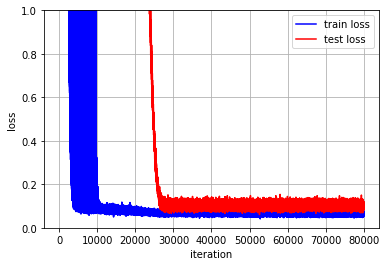

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
plt.plot(loss_vec,c='b',linestyle='solid',label='train loss')

plt.plot(test_loss_vec,c='r',label='test loss')

#plt.xlim(60000,60100)
plt.ylim(0,1)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.savefig(str(hidden_size)+'.png')
plt.legend()


#print(test_loss_vec[99999])
#print(test_loss_vec[99999])

In [10]:
# 重みの保存
saver = tf.train.Saver()
saver.save(sess, './model.ckpt')


'./model.ckpt'

In [11]:
'''
# ボール座標とスティックの傾きプロット
by_max=IN_train.max(axis=0)[1]
by_min=IN_train.min(axis=0)[1]

ball_y = np.array(range(int(by_min)-3,int(by_max)+3))
for i in range(len(ball_y)):
    
    ball = np.array([[6.0, ball_y[i]/10.0]])
    
    print(ball)
    joy = sess.run(final_output, feed_dict={INPUT: ball})
    plt.scatter(ball[0][1],ball[0][0], s=200, c='orange')
    
    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)
    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)
    print(joy)
    plt.savefig(str(hidden_size)+'_img'+'.png')
    '''

'\n# ボール座標とスティックの傾きプロット\nby_max=IN_train.max(axis=0)[1]\nby_min=IN_train.min(axis=0)[1]\n\nball_y = np.array(range(int(by_min)-3,int(by_max)+3))\nfor i in range(len(ball_y)):\n    \n    ball = np.array([[6.0, ball_y[i]/10.0]])\n    \n    print(ball)\n    joy = sess.run(final_output, feed_dict={INPUT: ball})\n    plt.scatter(ball[0][1],ball[0][0], s=200, c=\'orange\')\n    \n    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)\n    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)\n    print(joy)\n    plt.savefig(str(hidden_size)+\'_img\'+\'.png\')\n    '

In [12]:
# 重みのrestore
predicts_sess = tf.Session(config=config)
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt
